## Журнал "Петрология": анализ публикативной активности 3/3

<hr style="border:solid orange 1px">

### Уровень цитирующих изданий

---

Основные задачи данного анализа оценить:
- оценить какие журналы ссылаются на статьи в нашем журнале с учетом их импакт-фактора (квартиля);
- подготовить функционал для анализа данных с учетом самоцитирования и без.

В качестве исходных данных используются свободные сведения о цитировании публикаций в системе `Scopus`.  Данные представляют собой таблицу с данными по цитируемости статей одного выпуска (года) по годам. Исходные данные достаточно простые, верные и не требует специальной предобработки.

Данные предоставлены за период `2014-2020` год. Базы актуальны на `сентябрь 2020 года`. Хотя, конечно, ясно, что данные по 2019 и 2020 году пока неполные.

---

In [23]:
# Подключим библиотеки, которые будем использовать в проекте...
import pandas as pd
import numpy as np
import glob

# Библиотеки для построения графиков:
import matplotlib.pyplot as plt
import seaborn as sns

# Модуль для игнорирования ошибок и предупреждений:
import warnings
warnings.simplefilter('ignore')

# Изображение картинок в хорошем качестве:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

---

### База данных журналов и их импакт факторов по Web of Science

In [2]:
# Загружаем исходные данные:
journal_if = pd.read_excel('data/if.xlsx')

# Добавляем нужные столбцы:
journal_if['journal'] = ''
journal_if['if'] = ''

# Определяем паттерны для изъятия названия журнала и его импакт фактора:
pattern = '\d ((.+)) \d'
pattern1 = '\d ((.+))'
pattern2 = '(\d+.+)'

# Выделяем название журнала отдельно, и его импакт фактор:
journal_if['journal'] = journal_if['Rank Full Journal Title'].str.lower().str.extract(pat = pattern)[0]
journal_if['if'] = (
   (journal_if['Rank Full Journal Title'].str.lower().str.extract(pat = pattern1)[0])
   .str.extract(pat = pattern2)[0])

# Создаем итоговую версию таблицы:
journal_if = journal_if[['journal','if','q']].dropna()

In [24]:
journal_if.head()

,journal,if,q
0,ca-a cancer journal for clinicians,292.278,Q1
1,new england journal of medicine,74.699,Q1
2,nature reviews materials,71.189,Q1
3,nature reviews drug discovery,64.797,Q1
4,lancet,60.392,Q1


In [3]:
# Проверяем импакт фактор на примере журнала Петрология:
journal_if.query('journal == "petrology"')

,journal,if,q
9895,petrology,1.391,Q3


--- 

### Анализ цитируемости публикаций журнала Петрология за 2014-2020 годы

In [4]:
# Загружаем цитаты с учетом самоцитирования:
path = r'data\citations\with_sc'
all_files = glob.glob(path + "/*.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['cited_year'] = filename
    df['cited_year'] = df['cited_year'].str.extract(r'([ab])?(\d+)')[1]
    li.append(df)
    
citedby = pd.concat(li, axis=0, ignore_index=True)

In [5]:
# Загружаем цитаты без учета самоцитирования:
path = r'data\citations\wo_sc'
all_files = glob.glob(path + "/*.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['cited_year'] = filename
    df['cited_year'] = df['cited_year'].str.extract(r'([ab])?(\d+)')[1]
    li.append(df)
    
wsc_citedby = pd.concat(li, axis=0, ignore_index=True)

In [6]:
# Агрегация двух сводных таблиц, которые суммируют кол-во ссылок по названию журнала и году публикации (цитируемой):
# С учетом самоцитирования:
citedby_total = (citedby
     .groupby(['Название источника','Год','cited_year'])
     .agg({'Название' : 'count'})
     .reset_index())
citedby_total['self_citing'] = True

# Данные без учета самоцитирования:
wsc_citedby_total = (wsc_citedby
     .groupby(['Название источника','Год','cited_year'])
     .agg({'Название' : 'count'})
     .reset_index())
wsc_citedby_total['self_citing'] = False

# Объежинение двух таблиц в единую, для дальнейшей работы:
cited_journals = citedby_total.append(wsc_citedby_total, ignore_index=True)

# Переименуем для удобства столбцы:                   
cited_journals.columns = ('journal', 'year', 'cited_year', 'cites', 'self_citing')

# Перевод названий журналов в нижний регистр для удобства:
cited_journals['journal'] = cited_journals['journal'].str.lower()

In [7]:
# Создание новой таблицы, которая будет учитывать квартиль журнала
tmp = cited_journals.merge(journal_if, how='left', left_on='journal', right_on='journal')

# Разделяем новую таблицу на две по типу цитирования и удаляем дубликаты:
tmp1 = tmp.query('self_citing == True').drop_duplicates(subset=['journal', 'year', 'cited_year'])
tmp2 = tmp.query('self_citing == False').drop_duplicates(subset=['journal', 'year', 'cited_year'])

# Делаем повторное объединение:
citations = tmp1.append(tmp2, ignore_index=True)

# Выполняем пропуски для журналов, которые не входят в базу WOS:
citations.loc[(citations['if'].isna()), 'if'] = '0'
citations.loc[(citations['q'].isna()), 'q'] = 'WO'

# Добавляем новый столбце, в котором будет название журнала и его квартиль:
citations['journal_q'] = citations['journal'].str.cat(citations['q'],sep=" - ")

In [8]:
# Смотрим, что вышло:
citations.head(10)

,journal,year,cited_year,cites,self_citing,if,q,journal_q
0,acta geochimica,2016,2014,1,True,0,WO,acta geochimica - WO
1,acta geologica sinica,2016,2016,1,True,0,WO,acta geologica sinica - WO
2,acta geologica sinica,2018,2016,1,True,0,WO,acta geologica sinica - WO
3,american journal of science,2017,2014,1,True,3.150,Q1,american journal of science - Q1
4,american journal of science,2017,2017,1,True,3.150,Q1,american journal of science - Q1
5,american mineralogist,2017,2015,1,True,2.922,Q2,american mineralogist - Q2
6,american mineralogist,2018,2017,2,True,2.922,Q2,american mineralogist - Q2
7,american mineralogist,2019,2015,1,True,2.922,Q2,american mineralogist - Q2
8,american mineralogist,2019,2017,2,True,2.922,Q2,american mineralogist - Q2
9,annual review of earth and planetary sciences,2017,2014,1,True,9.089,Q1,annual review of earth and planetary sciences ...


In [9]:
# Смотрим, что вышло:
citations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741 entries, 0 to 740
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   journal      741 non-null    object
 1   year         741 non-null    int64 
 2   cited_year   741 non-null    object
 3   cites        741 non-null    int64 
 4   self_citing  741 non-null    bool  
 5   if           741 non-null    object
 6   q            741 non-null    object
 7   journal_q    741 non-null    object
dtypes: bool(1), int64(2), object(5)
memory usage: 41.4+ KB


---

Данные готовы для анализа, можно приступать к оценке цитируемости публикаций журнала. Проанализируем общее количество цитат по журналам:

In [10]:
# Функция, для отображения кол-ва значений:
# https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() -0.2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", fontsize=8)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [11]:
# Выявим журналы, которые имеют большое кол-во ссылок на статьи:

# Но в начале определим временной срез:
year_start = 2014
year_end = 2020

# И количество топовых журналов:
journal_number = 15

# Проведем соответствующую агрегацию данных:
top_jornals = (citations
              .query('year >= @year_start and year <= @year_end')
              .groupby(['journal_q','self_citing'])
              .agg({'cites' : 'sum',})  
              .reset_index()
              .query('self_citing == True')
              .sort_values(by = 'cites', ascending = False)
              .head(journal_number)
              )

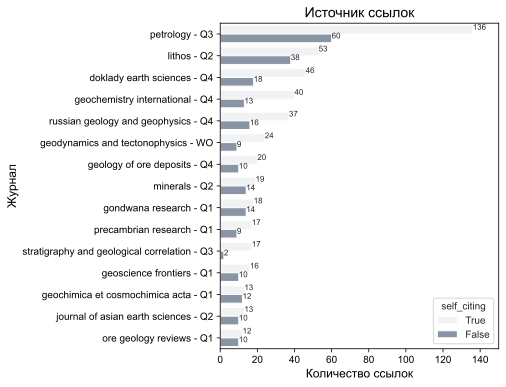

In [12]:
# И построим график. Для этого используем журналы, которые вошли в топ по цитатам:
top_journal_list = list(top_jornals['journal_q'].unique())
data = (citations
        .query('year >= @year_start and year <= @year_end')
        .query('journal_q in @top_journal_list')
        .groupby(['journal_q','self_citing'])
        .agg({'cites' : 'sum'})    
        .reset_index()
        .sort_values(by = 'cites', ascending = False)
       )

# И построим график:
plt.figure(figsize = (5,6))     # размер графика
plt.title("Источник ссылок", fontsize=14)    # Заголовок графика

# Основной стиль графика:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# Сетка графика:
plt.grid(b=True, which='major', color='black', linewidth=0.05)
plt.grid(b=True, which='minor', color='black', linewidth=0.05)

# Сам график:
g = sns.barplot(y = "journal_q", x = "cites", data = data, color="#8595A8", hue="self_citing", hue_order = (True, False))

# Подписи осей:
g.set_xlabel('Количество ссылок', fontsize=12)
g.set_ylabel('Журнал', fontsize=12)

# Масштаб осей:
g.set(xlim=(0, 150)) 

# Вызов функции для подписи значений на барах:
show_values_on_bars(g, "h", 0)

# Сохранение рисунка:
plt.savefig("images/top_journals.svg", dpi=300, transparent=True, bbox_inches = "tight")

In [26]:
# Отдельно посмотрим на топ 20 журналов с учетом самоцитирования:
citations_with_self_citations = (citations
        .query('year >= @year_start and year <= @year_end')
        .query('self_citing == True')
        .groupby(['journal_q'])
        .agg({'cites' : 'sum'})    
        .reset_index()
        .sort_values(by = 'cites', ascending = False)
        .head(20)
       )
citations_with_self_citations['proportion'] = citations_with_self_citations['cites'].apply(lambda x: (x / citations_with_self_citations['cites'].sum()))
citations_with_self_citations

,journal_q,cites,proportion
95,petrology - Q3,136,0.257576
79,lithos - Q2,53,0.100379
20,doklady earth sciences - Q4,46,0.087121
28,geochemistry international - Q4,40,0.075758
103,russian geology and geophysics - Q4,37,0.070076
31,geodynamics and tectonophysics - WO,24,0.045455
40,geology of ore deposits - Q4,20,0.037879
89,minerals - Q2,19,0.035985
48,gondwana research - Q1,18,0.034091
99,precambrian research - Q1,17,0.032197


In [29]:
# Отдельно посмотрим на топ 20 журналов с без учета самоцитирования:
citations_wo_self_citations = (citations
        .query('year >= @year_start and year <= @year_end')
        .query('self_citing == False')
        .groupby(['journal_q'])
        .agg({'cites' : 'sum'})    
        .reset_index()
        .sort_values(by = 'cites', ascending = False)
        .head(20)
       )
citations_wo_self_citations['proportion'] = citations_wo_self_citations['cites'].apply(lambda x: (x / citations_wo_self_citations['cites'].sum()))
citations_wo_self_citations

,journal_q,cites,proportion
88,petrology - Q3,60,0.214286
73,lithos - Q2,38,0.135714
17,doklady earth sciences - Q4,18,0.064286
96,russian geology and geophysics - Q4,16,0.057143
44,gondwana research - Q1,14,0.050000
82,minerals - Q2,14,0.050000
25,geochemistry international - Q4,13,0.046429
27,geochimica et cosmochimica acta - Q1,12,0.042857
36,geology of ore deposits - Q4,10,0.035714
58,journal of asian earth sciences - Q2,10,0.035714


Данные по цитируемым источникам показывают, что:
- большая часть ссылок (порядка 25 %) приходится на собственно журнал `Петрология`;
- далее (около 10%) идет журнал `Lithos`, что в целом хорошо;
- следующие `5 журналов`, составляют от `8 до 3% цитирования` и являются, также как и `Петрология`, русскоязычными, переводными изданиями.

Анализ данных без самоцитирующих источников показывает примерно такое же распределение цитат, хотя англоязычные издания выходят несколько вперед.

---

Далее посмотрим на цитирования с точки зрения квартиля журнала с учетом самоцитирования:

In [30]:
# Далее посмотрим на цитирования с точки зрения квартиля журнала с учетом самоцитирования:
citations_proportion = (citations
    .query('year >= @year_start and year <= @year_end')
    .query('self_citing == True')
    .groupby(['q'])
    .agg({
         'cites' : 'sum',
         'journal' : 'nunique', 
         })
     .sort_values(by = 'q', ascending = True)
     .reset_index()
)
citations_proportion['cites_proportion'] = citations_proportion['cites'].apply(lambda x: (x / citations_proportion['cites'].sum() ))
citations_proportion.style.format({
            'cites_proportion': "{:.0%}"
})

,q,cites,journal,cites_proportion
0,Q1,141,28,19%
1,Q2,134,22,18%
2,Q3,184,16,25%
3,Q4,176,15,24%
4,WO,96,39,13%


Анализ квартилей цитирующих изданий показывает, что около `50%` цитат составляют журналы `3-4 квартилей`, по сути это русские журналы. Остальные `50%` занимают журналы `1-2 квартилей` (18-19%) и журналы без квартилей (13%). 

---

Далее посмотрим на цитирования с точки зрения квартиля журнала в целом без учета самоцитирования:

In [16]:
# Далее посмотрим на цитирования с точки зрения квартиля журнала в целом без учета самоцитирования:
citations_proportion_wosc = (citations
    .query('year >= @year_start and year <= @year_end')
    .query('self_citing == False')
    .groupby(['q'])
    .agg({
         'cites' : 'sum',
         'journal' : 'nunique', 
         })
     .sort_values(by = 'q', ascending = True)
     .reset_index()
)
citations_proportion_wosc['cites_proportion'] = citations_proportion_wosc['cites'].apply(lambda x: (x / citations_proportion_wosc['cites'].sum()))
citations_proportion_wosc.style.format({
            'cites_proportion': "{:.0%}"
})

,q,cites,journal,cites_proportion
0,Q1,108,24,25%
1,Q2,95,21,22%
2,Q3,88,16,21%
3,Q4,75,13,17%
4,WO,63,36,15%


Если отбросить самоцитирование, то журналы `1-2 квартилей` составляют `47%` (практически половину). Также увеличивается доля изданий без квартиля WoS.

---

Далее визуализируем данные:

In [31]:
# Собирем одну таблицу и построим гистограммы распределения цитат по квартилю журнала:
citations_proportion['type_of_citation'] = 'including self-citations'
citations_proportion_wosc['type_of_citation'] = 'without self-citations'

cited_journals = citations_proportion.append(citations_proportion_wosc, ignore_index=True)
cited_journals

,q,cites,journal,cites_proportion,type_of_citation
0,Q1,141,28,0.192886,including self-citations
1,Q2,134,22,0.183311,including self-citations
2,Q3,184,16,0.251710,including self-citations
3,Q4,176,15,0.240766,including self-citations
4,WO,96,39,0.131327,including self-citations
5,Q1,108,24,0.251748,without self-citations
6,Q2,95,21,0.221445,without self-citations
7,Q3,88,16,0.205128,without self-citations
8,Q4,75,13,0.174825,without self-citations
9,WO,63,36,0.146853,without self-citations


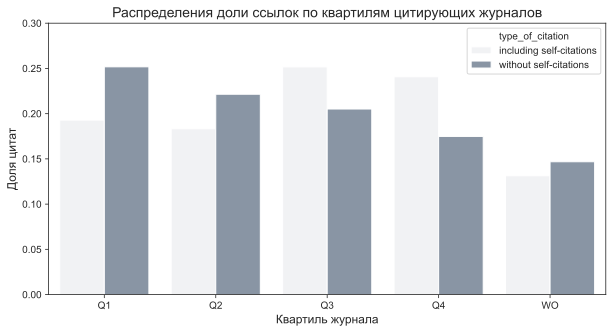

In [18]:
# И построим график. Для этого используем журналы, которые вошли в топ по цитатам:
# И построим график:
plt.figure(figsize = (10,5))     # размер графика
plt.title("Распределения доли ссылок по квартилям цитирующих журналов", fontsize=14)    # Заголовок графика

# Основной стиль графика:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# Сетка графика:
plt.grid(b=True, which='major', color='black', linewidth=0.05)
plt.grid(b=True, which='minor', color='black', linewidth=0.05)

# Сам график:
g = sns.barplot(y = "cites_proportion", x = "q", data = cited_journals, 
                color="#8595A8", hue="type_of_citation")

# Подписи осей:
g.set_xlabel('Квартиль журнала', fontsize=12)
g.set_ylabel('Доля цитат', fontsize=12)

# Масштаб осей:
g.set(ylim=(0, 0.3))

# Вызов функции для подписи значений на барах:
# show_values_on_bars(g, "h", 0)

# Сохранение рисунка:
plt.savefig("images/top_journals.svg", dpi=300, transparent=True, bbox_inches = "tight")

Визуализация данных наглядно подтверждает вышеуказанные предположения.

---

Далее посмотрим на количество цитат по году публикации цитирующей статьи.

In [32]:
# Далее посмотрим на количество цитат по году публикации цитирующей статьи:
data = (citations
    .query('self_citing == True')
    .groupby(['year','q'])
    .agg({
         'cites' : 'sum',
         'journal' : 'nunique', 
         })
    .reset_index()
)
data

,year,q,cites,journal
0,2014,Q1,1,1
1,2014,Q2,1,1
2,2014,Q3,1,1
3,2014,Q4,2,2
4,2014,WO,1,1
5,2015,Q1,1,1
6,2015,Q2,4,3
7,2015,Q3,7,2
8,2015,Q4,8,5
9,2015,WO,5,5


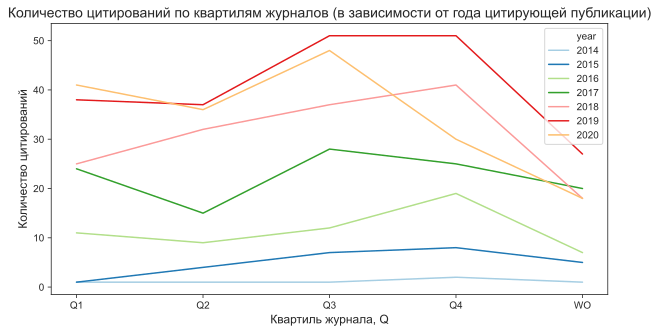

In [35]:
# Визуализируем данные:
plt.figure(figsize = (10,5))  

# Основной стиль графика:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# Сетка графика:
plt.grid(b=True, which='major', color='black', linewidth=0.05)
plt.grid(b=True, which='minor', color='black', linewidth=0.05)

# Сам график:
g = sns.lineplot(
        x='q', y=('cites'), legend = 'full', palette="Paired",
        data = data, hue = 'year'
)

# Название, подписи осей:
plt.title("Количество цитирований по квартилям журналов (в зависимости от года цитирующей публикации)", fontsize=14)
g.set_xlabel('Квартиль журнала, Q', fontsize=12)
g.set_ylabel('Количество цитирований', fontsize=12)

plt.xticks(rotation = 0)

# Сохранение рисунка:
plt.savefig("images/citation_per_Q.svg", dpi=300, transparent=True, bbox_inches = "tight")

Поскольку данные содержать только цитируемость с 2014 года публикаций, опубликованных в `2014-2020 годах`, то вполне логично, что количество цитат постепенно увеличивается с годами. Обращает на себя внимание то, что:
- примерно все исследуемые годы количество цитат увеличивается с уменьшением квартиля журнала, возможным исключением является `2017 год`;
- в последние годы хорошо видно, что происходит доминирование журналов `3-4 квартиля`.

In [21]:
# Далее посмотрим на количество цитат по году публикации цитируемых статей:
data = (citations
    .query('self_citing == True')
    .groupby(['cited_year','q'])
    .agg({
         'cites' : 'sum',
         'journal' : 'nunique', 
         })
    .reset_index()
)
data

,cited_year,q,cites,journal
0,2014,Q1,44,16
1,2014,Q2,32,12
2,2014,Q3,63,9
3,2014,Q4,51,11
4,2014,WO,18,14
5,2015,Q1,31,13
6,2015,Q2,23,9
7,2015,Q3,33,6
8,2015,Q4,39,7
9,2015,WO,14,5


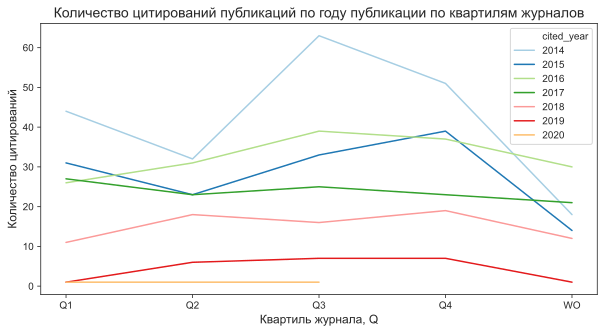

In [22]:
# Визуализируем данные:
plt.figure(figsize = (10,5))  

# Основной стиль графика:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# Сетка графика:
plt.grid(b=True, which='major', color='black', linewidth=0.05)
plt.grid(b=True, which='minor', color='black', linewidth=0.05)

# Сам график:
g = sns.lineplot(
        x='q', y=('cites'), legend = 'full', palette="Paired",
        data = data, hue = 'cited_year'
)

# Название, подписи осей:
plt.title("Количество цитирований публикаций по году публикации по квартилям журналов", fontsize=14)
g.set_xlabel('Квартиль журнала, Q', fontsize=12)
g.set_ylabel('Количество цитирований', fontsize=12)

plt.xticks(rotation = 0)

# Сохранение рисунка:
plt.savefig("images/citation_per_Q.svg", dpi=300, transparent=True, bbox_inches = "tight")

Поскольку данные содержать только цитируемость с 2014 года публикаций, опубликованных в `2014-2020 годах`, то вполне логично, что количество цитат статей в журнале, опубликованных в 2014 году самое большое. В целом, данные подтверждают выше предложенные выводы, в честности в том, что публикации 2017 года имеют повышенное цитирование в журналах первого квартиля.

<hr style="border:solid orange 1px">

### Промежуточные выводы

---

Анализ данных по цитирующим источникам показал, что:
- большая часть ссылок (порядка 25 %) приходится на собственно журнал `Петрология`;
- далее (около 10%) идет журнал `Lithos`, что в целом хорошо;
- следующие `5 журналов`, составляют от `8 до 3% цитирования` и являются, также как и `Петрология`, русскоязычными, переводными изданиями;
- анализ данных без самоцитирующих источников показывает примерно такое же распределение цитат, хотя англоязычные издания выходят несколько вперед. 

Анализ квартилей цитирующих изданий показывает, что около `50%` цитат составляют журналы `3-4 квартилей`, по сути это русские журналы. Остальные `50%` занимают журналы `1-2 квартилей` (18-19%) и журналы без квартилей (13%). При этом, если отбросить самоцитирование, то на первое место выходят журналы `1-2 квартилей` - `47%` (практически половину). Также увеличивается доля изданий без квартиля WoS.

Поскольку данные содержать только цитируемость с 2014 года публикаций, опубликованных в `2014-2020 годах`, то вполне логично, что количество цитат постепенно увеличивается с годами. Обращает на себя внимание то, что:
- примерно все исследуемые годы количество цитат увеличивается с уменьшением квартиля журнала, возможным исключением является `2017 год`;
- в последние годы хорошо видно, что происходит доминирование журналов `3-4 квартиля`.
